# Figure 3

## Imports

In [13]:
import dolfin
import matplotlib.pyplot as plt
import os
import shutil
import pandas

import dolfin_mech as dmech

## Creating folder for temporary files

In [14]:
current_directory=os.getcwd()
new_directory="calc_fig3"
res_basename = os.path.join(current_directory, new_directory)

try:
    shutil.rmtree(res_basename)
except OSError:
    pass

os.mkdir(res_basename)

clean_upon_completion=True

## Parameters

### Mesh

In [15]:
cube_params = {"path_and_mesh_name" : str(current_directory)+"/Meshes/generic_lung.xdmf"}

### Material

In [16]:
alpha_lst=[0.016, 0.16, 1.6] ### values of alpha investigated, in kPa
params = {
        "alpha": 0.16, ### kPa
        "gamma":0.5, ### [-]
        "c1":0.6, ### kPa
        "c2":0., ## kPa, but obsolete parameter
        "kappa":1e2,  ### kPa
        "eta":1e-5,   ### [-]
        "rho_solid":1.06e-6} ### g/mm3

mat_params = {"scaling":"linear", "parameters": params}

### Loading

In [17]:
pi = -2. # kPa

pe = -0.5 # kPa

g = 9.81e3 # mm/s2

## Computing pressure-volume responses

In [18]:
results = {}

gravity_lst = [0, 1]

for gravity_ in gravity_lst:
    for alpha_ in alpha_lst:

        mat_params["parameters"]["alpha"] = alpha_
        load_params_inverse = {
            "type":"p_boundary_condition0", "f":gravity_*g, "P0":float(pe)}
        load_params_direct_inhalation= {
            "type":"p_boundary_condition", "f_lst":[gravity_*g, gravity_*g], "P0_lst":[0., float(pi)]}
        
        
        U_exhal_to_unloaded, phis_unloaded, dV_exhal = dmech.run_RivlinCube_PoroHyperelasticity(
                    inverse=1,
                    dim=3,
                    mat_params=mat_params,
                    load_params=load_params_inverse,
                    res_basename = res_basename+"/inverse",
                    get_results=1,
                    inertia_params={"applied":True, "rho_val":1e-8},
                    step_params={"dt_min":1e-4, "dt_ini":0.125},
                    cube_params=cube_params,
                    verbose=1)
        
        ### computing the end-inhalation configuration
        U_unloaded_to_inhal, phis_inhal, dV_unloaded = dmech.run_RivlinCube_PoroHyperelasticity(
            inverse=0,
            dim=3,
            mat_params=mat_params,
            load_params=load_params_direct_inhalation,
            res_basename = res_basename+"/direct",
            get_results=1,
            inertia_params={"applied":True, "rho_val":1e-8},
            step_params={"n_steps":2, "Deltat": 1., "dt_ini":0.05, "dt_max":0.05, "dt_min":1e-4}, 
            cube_params=cube_params,
            porosity_params= {"type": "function_xml_from_array", "val":phis_unloaded},
            move_params = {"move":True, "U":U_exhal_to_unloaded},
            verbose=1)

        V_exhal=dolfin.assemble(dolfin.Constant(1.)*dV_exhal)

        v_lst = pandas.read_csv(
            res_basename+"/direct-qois.dat",
            delim_whitespace=True,
            comment="#",
            names=open(res_basename+"/direct-qois.dat").readline()[1:].split()).to_dict('list')["v"]
        t_lst = pandas.read_csv(
            res_basename+"/direct-qois.dat",
            delim_whitespace=True,
            comment="#",
            names=open(res_basename+"/direct-qois.dat").readline()[1:].split()).to_dict('list')["t"]

        results["pi_alpha="+str(alpha_)+"g="+str(gravity_)]=[-1*(2*t-1)*float(pi) for t in t_lst if t>=0.5]
        results["J_alpha="+str(alpha_)+"g="+str(gravity_)]=[v_lst[c]/V_exhal for c in range(len(t_lst)) if t_lst[c]>=0.5]

load_type p_boundary_condition0
load_type p_boundary_condition
load_type p_boundary_condition0
load_type p_boundary_condition
load_type p_boundary_condition0
load_type p_boundary_condition
load_type p_boundary_condition0
load_type p_boundary_condition
load_type p_boundary_condition0
load_type p_boundary_condition
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
load_type p_boundary_condition0
load_type p_boundary_condition
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points


In [19]:
if clean_upon_completion:
    shutil.rmtree(res_basename, ignore_errors=1)

## Generating plots

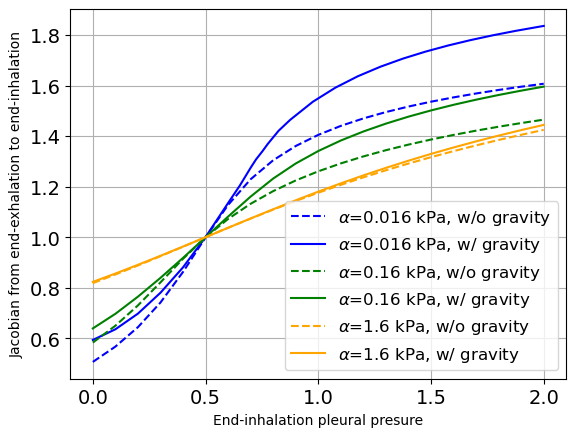

In [20]:
fig, ax = plt.subplots()
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)
plt.rc("legend", fontsize=12)
plt.xlabel("End-inhalation pleural presure", fontsize=10)
plt.ylabel("Jacobian from end-exhalation to end-inhalation", fontsize=10)
color_lst = ["blue", "green", "orange"]

for alpha_ in alpha_lst:
    for gravity_ in gravity_lst:
        if gravity_:
            linestyle = "-"
            g = "w/ gravity"
        else:
            linestyle = "--"
            g = "w/o gravity"
        plt.plot(results["pi_alpha="+str(alpha_)+"g="+str(gravity_)], results["J_alpha="+str(alpha_)+"g="+str(gravity_)], color=color_lst[0], linestyle=linestyle, label=r"$\alpha$"+"="+str(alpha_)+" kPa, "+str(g))
    color_lst=color_lst[1:]
plt.legend()
plt.grid()
plt.show()

In [21]:
# v_lst
V_exhal

2259030.653829326